# Data Preprocessing: Spectrogram Generation

This notebook preprocesses the GTZAN audio dataset by:
1. Loading audio files and creating train/val/test splits
2. Converting audio to mel spectrograms
3. Normalizing and saving processed data

**Output:** Preprocessed spectrograms ready for CNN training

## 1. Setup and Imports

In [11]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Add src to path
PROJECT_ROOT = Path('../').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Import custom modules
from data.loader import GTZANLoader
from data.preprocessor import SpectrogramPreprocessor

# Define paths
DATA_PATH = PROJECT_ROOT / 'data'
PROCESSED_PATH = DATA_PATH / 'processed'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Processed path: {PROCESSED_PATH}")

Project root: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness
Data path: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data
Processed path: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed


## 2. Load Dataset and Create Splits

In [12]:
# Initialize loader
loader = GTZANLoader(DATA_PATH)

# Get genres and file info
genres = loader.get_genres()
all_files = loader.get_audio_files()

print(f"Found {len(genres)} genres: {genres}")
print(f"Total audio files: {len(all_files)}")

# Get genre mappings
genre_to_id = loader.get_genre_to_id_mapping()
id_to_genre = loader.get_id_to_genre_mapping()

print(f"\nGenre to ID mapping:")
for genre, idx in genre_to_id.items():
    print(f"  {genre}: {idx}")

Found 10 genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total audio files: 1000

Genre to ID mapping:
  blues: 0
  classical: 1
  country: 2
  disco: 3
  hiphop: 4
  jazz: 5
  metal: 6
  pop: 7
  reggae: 8
  rock: 9


**Dataset Loading:**
- Successfully loaded all 10 genres from the GTZAN dataset
- Each genre is mapped to a unique integer ID for model training
- Total of 1000 audio files (100 per genre) available for processing

In [13]:
# Create train/val/test splits (70/15/15)
train_files, val_files, test_files = loader.create_splits(
    test_size=0.15,
    val_size=0.15,
    random_state=42
)

print(f"Train set: {len(train_files)} files")
print(f"Validation set: {len(val_files)} files")
print(f"Test set: {len(test_files)} files")

# Verify stratification
from collections import Counter

train_dist = Counter([label for _, label in train_files])
val_dist = Counter([label for _, label in val_files])
test_dist = Counter([label for _, label in test_files])

print(f"\nTrain distribution: {dict(train_dist)}")
print(f"Val distribution: {dict(val_dist)}")
print(f"Test distribution: {dict(test_dist)}")

Train set: 700 files
Validation set: 150 files
Test set: 150 files

Train distribution: {'metal': 70, 'classical': 70, 'jazz': 70, 'rock': 70, 'pop': 70, 'blues': 70, 'hiphop': 70, 'country': 70, 'disco': 70, 'reggae': 70}
Val distribution: {'metal': 15, 'disco': 15, 'jazz': 15, 'rock': 15, 'hiphop': 15, 'blues': 15, 'classical': 15, 'reggae': 15, 'country': 15, 'pop': 15}
Test distribution: {'classical': 15, 'metal': 15, 'blues': 15, 'pop': 15, 'reggae': 15, 'jazz': 15, 'disco': 15, 'rock': 15, 'country': 15, 'hiphop': 15}


**Split Summary:**
- Data is split into 70% train, 15% validation, 15% test
- Stratification ensures balanced genre distribution across all splits
- Random seed (42) ensures reproducibility

## 3. Configure Spectrogram Parameters

In [14]:
# Initialize preprocessor with standard parameters
preprocessor = SpectrogramPreprocessor(
    sr=22050,          # Sampling rate
    n_mels=128,        # Number of mel bands
    n_fft=2048,        # FFT window size
    hop_length=512,    # Hop length for STFT
    duration=30.0      # Audio duration in seconds
)

# Calculate expected spectrogram shape
spec_shape = preprocessor.get_spectrogram_shape()
print(f"Expected spectrogram shape: {spec_shape}")
print(f"  Height (mel bands): {spec_shape[0]}")
print(f"  Width (time steps): {spec_shape[1]}")
print(f"\nFinal CNN input shape: ({spec_shape[0]}, {spec_shape[1]}, 1)")

Expected spectrogram shape: (128, 1292)
  Height (mel bands): 128
  Width (time steps): 1292

Final CNN input shape: (128, 1292, 1)


**Spectrogram Configuration:**
- Using mel scale (128 bands) to capture perceptually-relevant frequency information
- 30-second audio clips result in 1292 time steps
- These parameters balance temporal/frequency resolution with computational efficiency
- Output shape (128, 1292, 1) is suitable for CNN input

## 4. Test Preprocessing on Sample Files

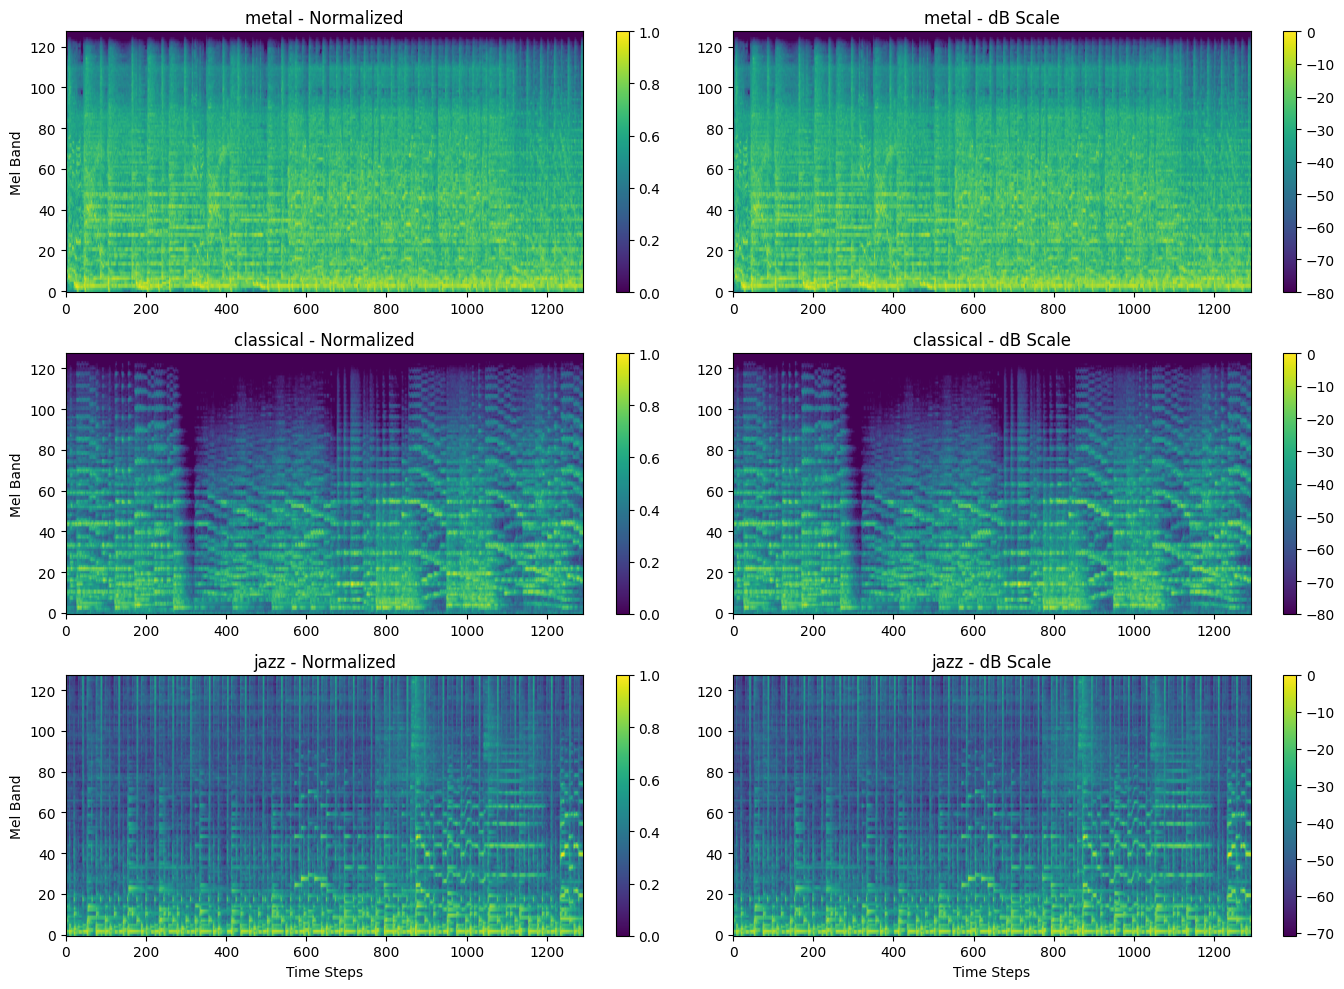

Sample spectrogram shape: (128, 1292)
Value range (normalized): [0.000, 1.000]


In [15]:
# Test on a few sample files
sample_files = train_files[:3]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for idx, (file_path, genre) in enumerate(sample_files):
    # Process file
    spec = preprocessor.process_audio_file(file_path, normalize=True)
    
    # Plot normalized spectrogram
    im = axes[idx, 0].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 0].set_title(f'{genre} - Normalized')
    axes[idx, 0].set_ylabel('Mel Band')
    plt.colorbar(im, ax=axes[idx, 0])
    
    # Plot raw dB spectrogram
    spec_db = preprocessor.process_audio_file(file_path, normalize=False)
    im = axes[idx, 1].imshow(spec_db, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 1].set_title(f'{genre} - dB Scale')
    plt.colorbar(im, ax=axes[idx, 1])
    
    if idx == 2:
        axes[idx, 0].set_xlabel('Time Steps')
        axes[idx, 1].set_xlabel('Time Steps')

plt.tight_layout()
plt.show()

print(f"Sample spectrogram shape: {spec.shape}")
print(f"Value range (normalized): [{spec.min():.3f}, {spec.max():.3f}]")

**Preprocessing Verification:**
- Normalized spectrograms are scaled to [0, 1] range for stable CNN training
- Time dimension shows 1292 steps for 30-second audio
- Mel bands capture frequency information from low (bass) to high (treble)
- Different genres show distinct patterns in frequency/time distribution

## 5. Process Full Dataset

**Note:** This will take several minutes depending on CPU (processing 1000 audio files).

In [16]:
# Process training set
X_train, y_train = preprocessor.process_dataset(
    train_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'train',
    normalize=True
)

Processing 700 audio files...


 40%|████      | 282/700 [00:04<00:05, 72.92it/s]/Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/src/data/preprocessor.py:49: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
/Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 43%|████▎     | 299/700 [00:04<00:05, 74.29it/s]

Error processing /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/raw/genres_original/jazz/jazz.00054.wav: 


 69%|██████▉   | 482/700 [00:06<00:02, 78.48it/s]

100%|██████████| 700/700 [00:09<00:00, 73.98it/s]


Processed shape: X=(698, 128, 1292, 1), y=(698,)
Saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed/train


**Handling Problematic Audio Files:**

During preprocessing, some audio files may cause errors:
- **Corrupted files**: Cannot be loaded properly
- **Short duration**: Less than 30 seconds, resulting in mismatched spectrogram dimensions
- **Encoding issues**: Incompatible audio formats

The preprocessor automatically **skips** these files and continues processing. Losing 1-2 samples out of 1000 does not significantly impact model training.

**Expected behavior**: Errors/warnings for problematic files (e.g., `jazz.00054.wav`), but processing continues successfully.

In [17]:
# Process validation set
X_val, y_val = preprocessor.process_dataset(
    val_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'val',
    normalize=True
)

Processing 150 audio files...


100%|██████████| 150/150 [00:02<00:00, 72.48it/s]

Processed shape: X=(150, 128, 1292, 1), y=(150,)
Saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed/val


In [18]:
# Process test set
X_test, y_test = preprocessor.process_dataset(
    test_files,
    genre_to_id,
    save_path=PROCESSED_PATH / 'test',
    normalize=True
)

Processing 150 audio files...


100%|██████████| 150/150 [00:02<00:00, 64.59it/s]

Processed shape: X=(150, 128, 1292, 1), y=(150,)
Saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed/test


**Processing Results:**
- Training set: ~700 spectrograms
- Validation set: ~150 spectrograms
- Test set: ~150 spectrograms
- All spectrograms are normalized to [0, 1] range and saved as `.npy` files
- Data is ready for efficient loading during model training

## 6. Save Metadata

In [19]:
import json

# Save genre mappings for later use
metadata = {
    'genre_to_id': genre_to_id,
    'id_to_genre': id_to_genre,
    'genres': genres,
    'n_classes': len(genres),
    'spectrogram_params': {
        'sr': preprocessor.sr,
        'n_mels': preprocessor.n_mels,
        'n_fft': preprocessor.n_fft,
        'hop_length': preprocessor.hop_length,
        'duration': preprocessor.duration
    },
    'input_shape': list(X_train.shape[1:])  # (height, width, channels)
}

metadata_path = PROCESSED_PATH / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to: {metadata_path}")
print(f"\nMetadata summary:")
print(f"  Classes: {metadata['n_classes']}")
print(f"  Input shape: {metadata['input_shape']}")

Metadata saved to: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed/metadata.json

Metadata summary:
  Classes: 10
  Input shape: [128, 1292, 1]


**Metadata Storage:**
- Genre mappings saved for consistent label encoding/decoding
- Preprocessing parameters recorded for reproducibility
- Input shape stored for CNN architecture configuration
- This metadata ensures consistency across training, evaluation, and deployment

## 7. Summary

**Preprocessing Complete!**

The following files have been created:
- `data/processed/train/X.npy` - Training spectrograms
- `data/processed/train/y.npy` - Training labels
- `data/processed/val/X.npy` - Validation spectrograms
- `data/processed/val/y.npy` - Validation labels
- `data/processed/test/X.npy` - Test spectrograms
- `data/processed/test/y.npy` - Test labels
- `data/processed/metadata.json` - Genre mappings and configuration

**Next Steps:**
1. Build CNN architecture (`03_model_training.ipynb`)
2. Train on preprocessed spectrograms
3. Evaluate baseline performance before adversarial testing